Cult Characters

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from cult_part_helpers import *
import plotly.express as px
import plotly.graph_objects as go



ABS_PATH = os.getcwd()
awards_df =pd.read_csv(ABS_PATH+'/data/the_oscar_award.csv')
movies_df = pd.read_csv(ABS_PATH+'/data/movie_data.csv')
character_df = pd.read_csv(ABS_PATH+'/data/CMU_dataset/character.metadata.tsv', sep='\t', names=[
    'movie_id', 'freebase_id', 'release_date', 'character_name', 'actor_dob', 'actor_gender', 
    'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'character_actor_map_id', 
    'character_freebase_id', 'actor_freebase_id'])
tmdb_df = pd.read_csv('data/TMDB_dataset_csv/MOVIE.csv')
character_metadata = character_df.copy()
plot_summaries = pd.read_csv(ABS_PATH+'/data/CMU_dataset/plot_summaries.txt', sep='\t', names=['movie_id', 'plot_summary'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mehdibouchoucha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mehdibouchoucha/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


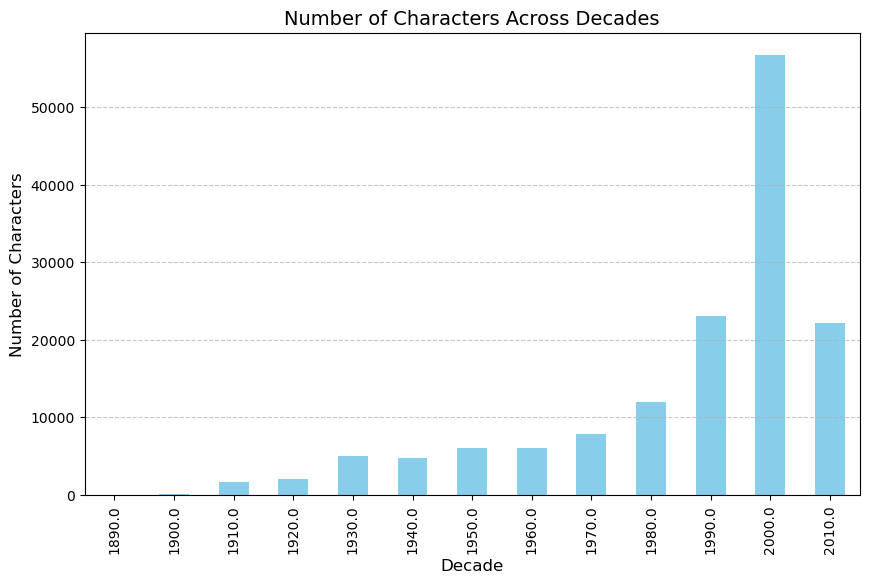

In [2]:
# Convert release_date to datetime
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

# Extract decade
character_df['decade'] = (character_df['release_date'].dt.year // 10) * 10

# Filter to only include rows with valid release dates
character_df = character_df.dropna(subset=['release_date'])

plot_nb_of_characters_by_decade(character_df)

In [3]:
df = plot_summaries.copy()
cult_movies_df = movies_df.copy()
df.columns = ['id', 'plot_summary']
merged_df = pd.merge(character_df, df, left_on='movie_id', right_on='id', how='inner')
actor_scores_df = pd.read_csv('output_data/actor_sentiment_popularity_scores.csv')
merged_df = clean_merged_df(merged_df)
actor_scores_df = clean_actor_scores_df(actor_scores_df)

# Merge actor sentiment and popularity scores with character data
merged_with_actor_df = pd.merge(merged_df, actor_scores_df, on='actor_name', how='left')
merged_with_actor_df = clean_merged_with_actor_df(merged_with_actor_df)

# Normalize movie names in movie_revenues
tmdb_df['normalized_title'] = tmdb_df['TITLE'].apply(normalize_name)
movies_df['normalized_title'] = movies_df['movie_title'].apply(normalize_name)

# Merge datasets based on normalized names
plots_df = pd.merge(tmdb_df, movies_df, how='inner', left_on='normalized_title', right_on='normalized_title')
plots_df = clean_plots_df(plots_df)


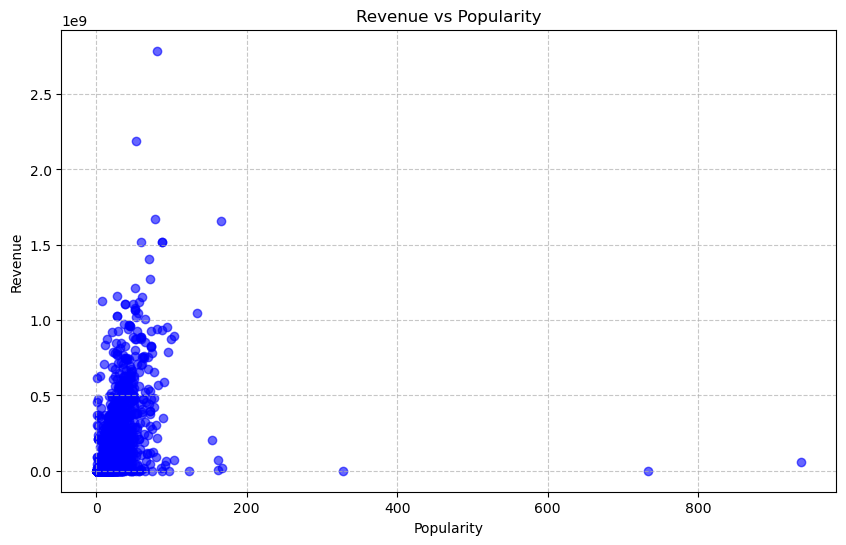

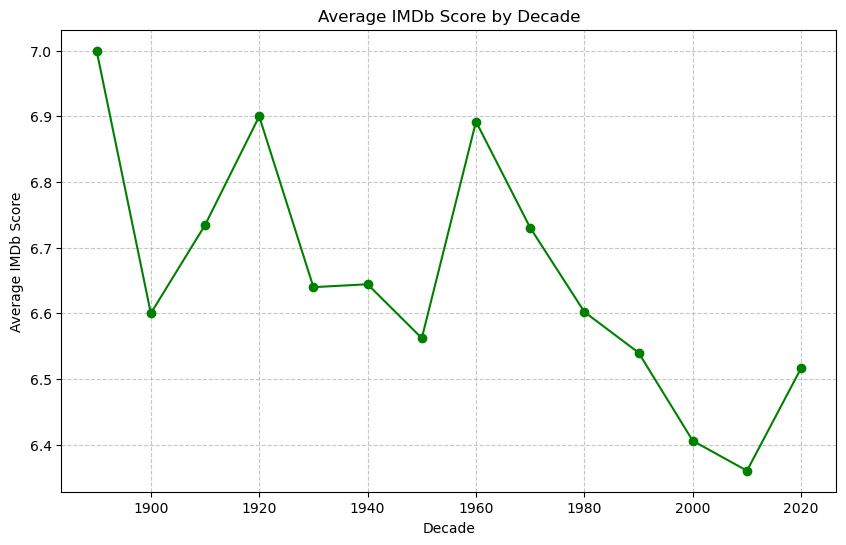

In [4]:
plot_revenue_vs_popularity(plots_df)
plot_avg_imdb_by_decade(plots_df)

SYMPATHETIC VILLAIN

In [5]:
plot_sym_villain_by_decade(character_metadata, plot_summaries)

CULT MOVIES

In [6]:
plot_movies(cult_movies_df)

In [10]:
movies_df['title_year'] = movies_df['title_year']
movies_df = movies_df.sort_values('title_year')
movies_df.dropna(subset=['title_year', 'movie_title', 'country'], inplace=True)
movies_df['decade'] = (movies_df['title_year'] //10 *10).astype(int).astype(str)
top_directors = oscars_to_directors(awards_df, movies_df)
top_50_directors = top_directors.nlargest(50, 'unique_movies_count')
# Create the interactive bar plot again with layout adjustments
fig = px.bar(
    top_50_directors,
    x='director_name',
    y='unique_movies_count',
    color='film',  # Different movies represented by different colors
    text='film',  # Display movie names
    title='Top Directors and Their Movies',
    labels={'unique_movies_count': 'Number of Oscar winning Movies', 'director_name': 'Director Name', 'film': 'Movie'},
    hover_data={'film': True}
)

# Customize layout for better visibility
fig.update_traces(textposition='inside', textfont_size=10)  # Move text inside bars and reduce font size
fig.update_layout(
    height=800,  # Increase plot height for more spacing
    margin=dict(l=50, r=50, t=100, b=150),  # Add margins to avoid clipping
    xaxis_title='Director Name',
    yaxis_title='Number of Movies',
    legend_title='Movies',
    showlegend=False  # Disable legend if the movie list is too large
)

# Show the plot
fig.show()

In [11]:
# Create a choropleth map with hover data showing the top movies
fig = px.choropleth(
    movies_df.sort_values('imdb_score').groupby(['country', 'decade']),
    locations=movies_df['country'].str.title(),
    locationmode="country names",
    color=movies_df['imdb_score'],
    animation_frame=movies_df['decade'],
    title="Evolution of popular movies in the world over the decades"
    ,
    color_continuous_scale=px.colors.sequential.Plasma,
)

# Update layout for better readability
fig.update_layout(
    title=dict(x=0.5),
    coloraxis_colorbar=dict(title="IMDB Score"),
    template="plotly_white",
    height=700
)

# Show the interactive map
fig.show()
